## Important imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import os
from tqdm import tqdm
import sklearn
import seaborn as sns
import plotly.express as px


import geopandas as gpd
from shapely.geometry import Point, Polygon

## EDA for Audio 

In [ ]:
filename = '../input/birdclef-2021/train_short_audio/annhum/XC151103.ogg'

### Visualizing Audio

In [ ]:
plt.figure(figsize=(18, 5))

# by default librosa.load returns a sample rate of 22050
# librosa converts input to mono, hence always 
data, sample_rate = librosa.load(filename)
librosa.display.waveplot(data, sr=sample_rate)
print("Sample Rate: ", sample_rate)
ipd.Audio(filename)

## Spectrogram
A spectrogram is a visual way of representing the signmal strength, or **"loudness"** of a signal over time at various frequencies present in a particular waveform.

In [ ]:
plt.figure(figsize=(18, 5))
X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

Converting frequency axis into log scale

In [ ]:
plt.figure(figsize=(18, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar()

## Feature Extraction

### 1. Spectral Centroid
The spectral centroid indicates at which frequency the energy of a spectrum is centered upon or in other words It indicates where the ” center of mass” for a sound is located. This is like a weighted mean:
    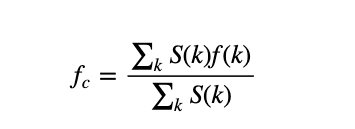
    where S(k) is the spectral magnitude at frequency bin k, f(k) is the frequency at bin k.

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(data, sr=sample_rate)[0]
plt.figure(figsize=(25, 9))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(data, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='b')

### 2. Spectral Rolloff
It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0.

In [ ]:
plt.figure(figsize=(25, 9))
spectral_rolloff = librosa.feature.spectral_rolloff(data+0.01, sr=sample_rate)[0]
librosa.display.waveplot(data, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

### 3. Spectral bandwidth
The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum [FWHM]) and is represented by the two vertical red lines and λSB on the wavelength axis.



In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(data+0.01, sr=sample_rate)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(data+0.01, sr=sample_rate, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(data+0.01, sr=sample_rate, p=4)[0]
plt.figure(figsize=(25, 9))
librosa.display.waveplot(data, sr=sample_rate, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))  # p: order of spectral bandwidth

### 4. Zero-Crosing Rate
A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, a 100 Hz signal will cross zero 100 per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

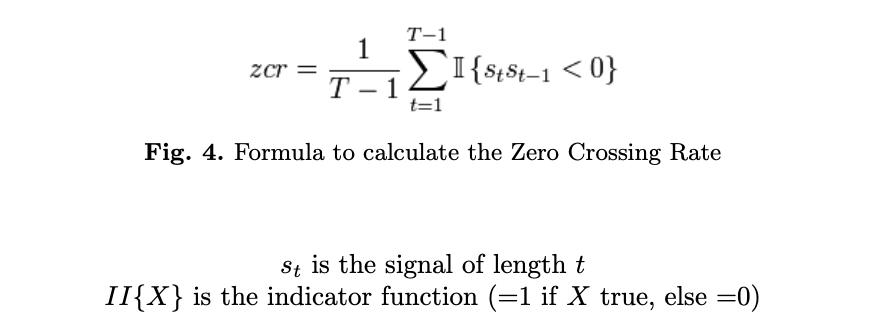

In [ ]:
#Plot the signal:
plt.figure(figsize=(25, 9))
# librosa.display.waveplot(data, sr=sample_rate)
# Zooming in
n0 = 9000
n1 = 9100

plt.plot(data[n0:n1])
plt.grid()

There are 57 zero crossing. Below if the code to verify it with librosa

In [ ]:
zero_crossings = librosa.zero_crossings(data[n0:n1], pad=False)
print(sum(zero_crossings)) #57

### 5. Mel-Frequency Cepstral Coefficients (MFCCs)
The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. 

In [ ]:
mfccs = librosa.feature.mfcc(data, sr=sample_rate)

#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()

### 6. Chrome features
A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal. 

In [ ]:
hop_length=512
chromagram = librosa.feature.chroma_stft(data, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(20, 8))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.colorbar()

*References:* I've used [this](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html) blog for EDA.

## EDA for data

In [ ]:
path = '../input/birdclef-2021/'
train_metadata = pd.read_csv(path + 'train_metadata.csv',)
train_csv = pd.read_csv(path + "train_soundscape_labels.csv")
test_csv = pd.read_csv(path + "test.csv")
sample_sub= pd.read_csv(path + "sample_submission.csv")


In [ ]:
train_metadata.head()

In [ ]:
print("There are total {} species".format(train_metadata['primary_label'].nunique()))

Top 25 species


In [ ]:
def plotbar(series, pal):
    plt.figure(figsize=(20, 9))
    chart = sns.barplot(x=series.index, y=series.values, edgecolor=(0,0,0), linewidth=2, palette=(pal))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
species = train_metadata['primary_label'].value_counts()[:25]
plotbar(species, "Blues_r") # series, palette

In [ ]:
sns.set(rc={'figure.figsize':(20,6)})
sns.countplot(x='rating', data=train_metadata, edgecolor=(0,0,0), linewidth=2, palette=('cubehelix'))


From above it is clear that there are only few files with low ratings

In [ ]:
authors = train_metadata['author'].value_counts()[:10]
plotbar(authors, "YlOrBr_r") # series, palette

Richard E. Webster is author having maximum file entries.

Top 25 training samples per species

In [ ]:
print("Common Name")
common = train_metadata['common_name'].value_counts()[:25]
plotbar(authors, "light:b_r") # series, palette

In [ ]:
print("Scientific Name")
scien = train_metadata['scientific_name'].value_counts()[:25]
plotbar(scien, "Greens_r") # series, palette

## Plot on Map
*References:* [Blog](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)

In [ ]:
# SHP file
world_map = gpd.read_file("../input/world-countries-shp-file/TM_WORLD_BORDERS-0.3.shp")
crs={'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(train_metadata["longitude"], train_metadata['latitude'])]

geo_df = gpd.GeoDataFrame(train_metadata, crs=crs, geometry=geometry)

# top 15 most species
species_list = species.reset_index()['index'].values[:15]

species_id = geo_df["primary_label"].value_counts().reset_index()
species_id.insert(0, 'ID', range(0, 0 + len(species_id)))

species_id.columns = ["ID", "primary_label", "count"]

# Add ID to geo_df
geo_df = pd.merge(geo_df, species_id, how="left", on="primary_label")


fig, ax = plt.subplots(figsize=(25, 15))
world_map.plot(ax=ax, alpha=0.7)

palette = iter(sns.hls_palette(len(species_list), h=.5))
for i in range(len(species_list)):
    geo_df[geo_df["ID"] == i].plot(ax=ax, 
                                   markersize=20, 
                                   color=next(palette), 
                                   marker="o", 
                                   label = species_id['primary_label'].values[i])
    
ax.legend()


In [ ]:
# SHP file
world_map = gpd.read_file("../input/world-countries-shp-file/TM_WORLD_BORDERS-0.3.shp")
crs={'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(train_metadata["longitude"], train_metadata['latitude'])]

geo_df = gpd.GeoDataFrame(train_metadata, crs=crs, geometry=geometry)

# top 15 most species
species_list = species.reset_index()['index'].values[:25]

species_id = geo_df["primary_label"].value_counts().reset_index()
species_id.insert(0, 'ID', range(0, 0 + len(species_id)))

species_id.columns = ["ID", "primary_label", "count"]

# Add ID to geo_df
geo_df = pd.merge(geo_df, species_id, how="left", on="primary_label")


fig, ax = plt.subplots(figsize=(25, 15))
world_map.boundary.plot(ax=ax, alpha=0.7)

palette = iter(sns.hls_palette(len(species_list), h=.5))
for i in range(len(species_list)):
    geo_df[geo_df["ID"] == i].plot(ax=ax, 
                                   markersize=20, 
                                   color=next(palette), 
                                   
                                   label = species_id['primary_label'].values[i])
    
ax.legend()

Recordings are very few from India (and other asian countries). Mostly recordings are from Europe and America

## To be continued .. .  .